In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import (
    pull_metrics_from_wandb,
    filter_zero_d,
    fit_power_law,
    predict_power_law,
    aggregate_steps,
    extract_ndy,
    plot_fit
)

In [2]:
ENTITY = "stanford-mercury"
PROJECT = "marin"

# define the list of smaller runs to use as "ladder" models
RUNS = [
    "tootsie-scaling-512-81c36c",
    "tootsie-scaling-768-d17a90",
    "tootsie-scaling-1024-f4e4be",
    "tootsie-scaling-1536-e2a6d8",
    "tootsie-scaling-2048-72c648",
]

# the large run to predict the performance of
PRED_RUN = "llama-8b-tootsie-0.001-19ad63"

# define the eval task loss metric
TASK_LOSS = "eval/paloma/c4_en/bpb"

TOKENS_COL = "throughput/total_tokens"
PARAM_COL = "parameter_count"

In [3]:
ladder_df = pull_metrics_from_wandb(
    runs=RUNS,
    metrics=[TASK_LOSS, TOKENS_COL],
    entity=ENTITY,
    project=PROJECT,
    summary_fields=[PARAM_COL]
)

In [4]:
ladder_df

,eval/paloma/c4_en/bpb,throughput/total_tokens,run,parameter_count,step
0,3.755196,0.000000e+00,tootsie-scaling-512-81c36c,248791552,0
1,1.039921,4.194304e+10,tootsie-scaling-512-81c36c,248791552,1
2,1.024333,8.388608e+10,tootsie-scaling-512-81c36c,248791552,2
3,1.018965,1.258291e+11,tootsie-scaling-512-81c36c,248791552,3
4,1.013399,1.677722e+11,tootsie-scaling-512-81c36c,248791552,4
5,1.000790,2.097110e+11,tootsie-scaling-512-81c36c,248791552,5
6,3.763502,0.000000e+00,tootsie-scaling-768-d17a90,461267712,0
7,0.987020,4.194304e+10,tootsie-scaling-768-d17a90,461267712,1
8,0.969680,8.388608e+10,tootsie-scaling-768-d17a90,461267712,2
9,0.962653,1.258291e+11,tootsie-scaling-768-d17a90,461267712,3


In [5]:
ladder_df_filtered = filter_zero_d(ladder_df, TOKENS_COL)
ladder_df_agg = aggregate_steps(ladder_df_filtered, step_mode="last")

In [6]:
N, D, y = extract_ndy(ladder_df_agg, PARAM_COL, TOKENS_COL, TASK_LOSS)
params = fit_power_law(N, D, y, use_log_space=True)
print("Fitted params (small runs):", params)
preds = predict_power_law(params, N, D)


Fitted params (small runs): (np.float64(1.0000000108867066), np.float64(0.9999999999860091), np.float64(0.9999999840392124), np.float64(1.0000000002456118), np.float64(0.9177216402798999))


In [7]:
print(N)
print(D)
print(y)

[ 732464128 1451017728 2337343488  248791552  461267712]
[2.09711006e+11 2.09711006e+11 2.09711006e+11 2.09711006e+11
 2.09711006e+11]
[0.91772169 0.8807596  0.86092269 1.00079024 0.94924712]


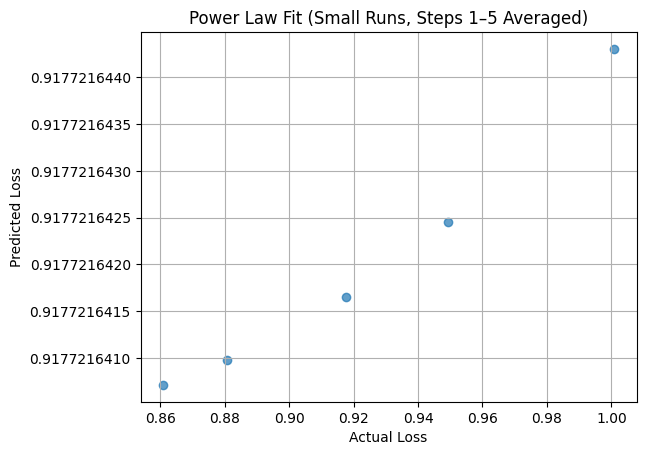

In [8]:
plot_fit(y, preds, "Power Law Fit (Small Runs, Steps 1–5 Averaged)")

In [10]:
pred_df = pull_metrics_from_wandb(
    runs=[PRED_RUN],
    metrics=[TASK_LOSS, TOKENS_COL],
    entity=ENTITY,
    project=PROJECT,
    summary_fields=[PARAM_COL]
)
pred_df_filtered = filter_zero_d(pred_df, d_key=TOKENS_COL)
pred_df_agg = aggregate_steps(pred_df_filtered, step_mode="last", step_range=(1,5))
N_pred, D_pred, y_pred = extract_ndy(pred_df_agg, PARAM_COL, TOKENS_COL, TASK_LOSS)
preds_big = predict_power_law(params, N_pred, D_pred)

print("\nPrediction on bigger run:")
for actual, pred in zip(y_pred, preds_big):
    print(f"  Actual: {actual:.4f}  |  Predicted: {pred:.4f}")


Prediction on bigger run:
  Actual: 0.8230  |  Predicted: 0.9177
